In [1]:
import pickle
from gensim.models import doc2vec
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sklearn import metrics

In [12]:
# corpus is compressed now
vocab = pickle.load(open('data/compressed_vocab.pickle', 'rb'))
pos2vocab = dict([(i[1], i[0]) for i in vocab.items()])
len(vocab)

222895

In [13]:
multiple_sig = pickle.load(open('data/multiple_sig_last_year.pickle', 'rb'))
prepared = [sig['prepared'] for sig in multiple_sig]
len(multiple_sig)

261

In [15]:
# multiple_sig[0]

In [9]:
# see BugzillaDownloader.ipynb for calculation details

In [29]:
def labels_to_clusters(labels):
    clusters = defaultdict(list)
    for i, c in enumerate(labels):
        if c != -1:
            clusters[c].append(i)
    return clusters

In [97]:
def predicted_for_group(group, predicted):
    rv = defaultdict(int)
    for g in group:
        for c, points in predicted.items():
            if g in points:
                rv[c] += 1
    return rv

def calc_accuracy(predicted, true):
    total = sum([len(i) for i in predicted.values()])     
    good = sum([max(predicted_for_group(g, predicted).values() or [0]) for g in true])
    return good / float(total)

In [16]:
groups = []
corpus = []
for p in prepared:
    group = []
    for t in p:
        corpus.append(t)
        group.append(len(corpus)-1)
    groups.append(group)
compressed_corpus = [[str(vocab.get(i, i)) for i in c] for c in corpus]
compressed_corpus = [doc2vec.TaggedDocument(trace, [i]) for i, trace in enumerate(compressed_corpus)]
groups = [g for g in groups if len(g) > 1]

In [17]:
len(compressed_corpus)

755

In [18]:
edit_dist_no_coff = pickle.load(open('data/edit_dist_no_coff_last_year.pickle', 'rb'))
edit_dist_no_coff.shape

(755, 755)

In [19]:
edit_dist_coff = pickle.load(open('data/edit_dist_coff_last_year.pickle', 'rb'))
edit_dist_coff.shape

(755, 755)

In [20]:
wmd_all = pickle.load(open('data/wmd_last_year.pickle', 'rb'))
wmd_all[wmd_all == np.inf] = -1
m = np.max(wmd_all)
wmd_all[wmd_all == -1] = m
wmd_all.shape

(755, 755)

In [21]:
np.mean(edit_dist_coff)

36.08441384122623

In [22]:
np.mean(edit_dist_no_coff)

30.378516731722293

In [23]:
np.mean(wmd_all)

1.2975248343326107

In [24]:
def dbscan(dist, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return labels, n_clusters, core_samples_mask

In [129]:
def plot_clusters(labels, n_clusters, core_samples_mask, dist, remove_outliers=True):
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            if remove_outliers:
                continue
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = dist[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=8)

        xy = dist[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=4)

    plt.title('Estimated number of clusters: %d' % n_clusters)
    plt.show()

In [27]:
labels, n_clusters, core_samples_mask = dbscan(wmd_all, min_samples=2)
n_clusters

117

In [98]:
clusters_wmd = labels_to_clusters(labels)
len(clusters_wmd), np.mean([len(i) for i in clusters_wmd.values()])

(117, 4.316239316239316)

In [103]:
calc_accuracy(clusters_wmd, groups)

0.7524752475247525

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


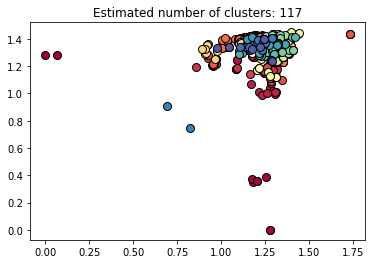

In [130]:
plot_clusters(labels, n_clusters, core_samples_mask, wmd_all)

In [153]:
labels_ec, n_clusters_ec, core_samples_mask_ec = dbscan(edit_dist_coff, eps=5, min_samples=2)
n_clusters_ec

106

In [154]:
calc_accuracy(labels_to_clusters(labels_ec), groups)

0.7627118644067796

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


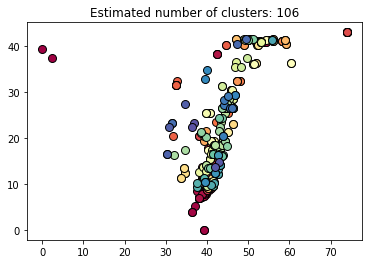

In [155]:
plot_clusters(labels_ec, n_clusters_ec, core_samples_mask_ec, edit_dist_coff)

In [132]:
labels_nec, n_clusters_nec, core_samples_mask_nec = dbscan(edit_dist_no_coff, eps=5, min_samples=2)
n_clusters_nec

105

In [156]:
calc_accuracy(labels_to_clusters(labels_nec), groups)

0.7505938242280285

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


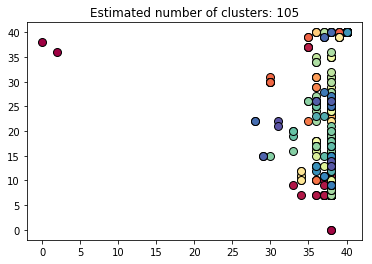

In [157]:
plot_clusters(labels_nec, n_clusters_nec, core_samples_mask_nec, edit_dist_no_coff)

In [28]:
def traces_in_cluster(cluster):
    return [corpus[i] for i in cluster]

In [ ]:
def distances_in_cluster(cluster, dist):
    rv = np.zeros((len(cluster), len(cluster)), dtype=np.double)
    return rv